In [1]:
%matplotlib inline
import os
from subprocess import call
from glob import glob
from itertools import product

import xarray as xr
import numpy as np
import dask

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import project as P
import geotools as gt
import plottools as pt
import cmocean


import importlib
importlib.reload(P)
USER = os.environ['USER']

In [2]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

dask.config.set({'distributed.dashboard.link':'http://localhost:{port}/status'})

# Lots of arguments to this command are set in ~/.config/dask/jobqueue.yaml
cluster = PBSCluster(queue='regular',
                     cores = 36,
                     processes = 9,
                     memory = '100GB',                     
                     project = 'NCGD0033',
                     walltime = '04:00:00',
                     local_directory=f'/glade/scratch/{USER}/dask-tmp')
client = Client(cluster)

In [3]:
Nnodes = 2
cluster.scale(9*Nnodes)

In [4]:
client

Client Scheduler: tcp://10.148.7.225:38131 Dashboard: http://localhost:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
clobber = False

file_out = f'{P.dirt}/work.npac.tend.skill.zarr'

forecast_leads = [(1,5),(3,7),(5,9)]

tend_variables = ['O2_lat_adv_res','O2_vert_adv_res',
                  'O2_dia_vmix','O2_adi_vmix',
                  'O2_lat_mix','O2_sms']


if clobber:
    call(['rm','-fr',file_out])

if os.path.exists(file_out):
    skill = xr.open_zarr(file_out)
else:
    skill = []
    for forecast_lead in forecast_leads:
        ds = P.dataview(forecast_lead=forecast_lead,apply_region_mask=False)

        skilli = xr.Dataset()
        for v in tend_variables+['O2_zint','O2_rhs_tend']:
            skilli[v+'_acc'] = P.xcorr(ds['dp'][v].mean('M'),ds['fosi'][v],dim='time')
            skilli[v+'_acc'].attrs = ds['fosi'][v].attrs

            skilli[v+'_rmse'] = P.rmsd(ds['dp'][v].mean('M'),ds['fosi'][v],dim='time')
            skilli[v+'_rmse'].attrs = ds['fosi'][v].attrs

            skilli[v+'_var'] = ds['fosi'][v].var(dim='time')
            skilli[v+'_var'].attrs = ds['fosi'][v].attrs
            
        skill.append(skilli)

    skill = xr.concat(skill,dim='forecast_lead')
    time_vars = [v for v in ds['fosi'].variables if 'time' in ds['fosi'][v].dims]
    skill = xr.merge((skill,ds['fosi'].drop(time_vars)))
    skill = skill.compute()
    print(f'writing {file_out}')
    skill.to_zarr(file_out)

In [8]:
cf_specs = {'acc' : {'levels':np.arange(-1,1.05,0.05),
                     'cmap':'PuOr_r',
                     'extend':'neither'},
            'rmse' : {'levels':np.arange(0,6.5,0.5),
                      'cmap':'Oranges',
                      'extend':'max'},
            'var' : {'levels':np.arange(0,6.5,0.5),
                     'cmap':'Oranges',
                     'extend':'max'}}

cax_title = {'acc' : 'ACC',
             'rmse' : 'RMSE\nmol m$^{-2}$ yr$^{-1}$',
             'var' : 'Variance\n(mol m$^{-2}$ yr$^{-1}$)$^{2}$'}

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


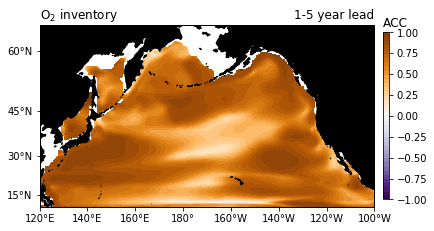

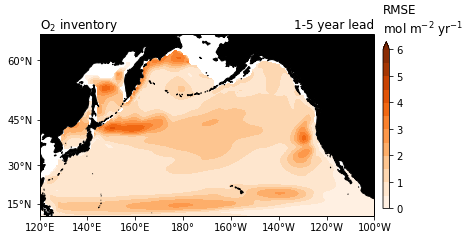

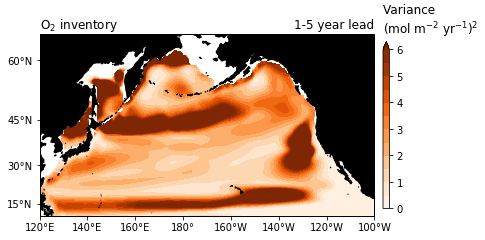

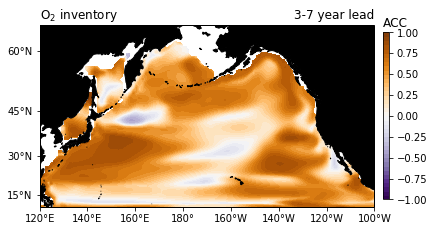

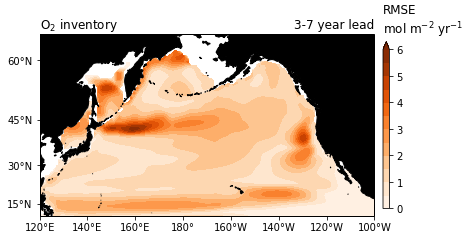

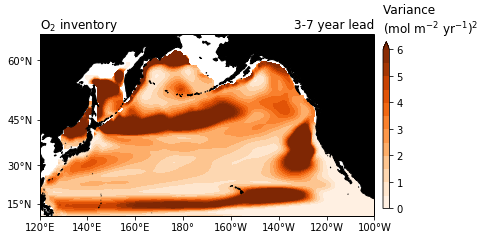

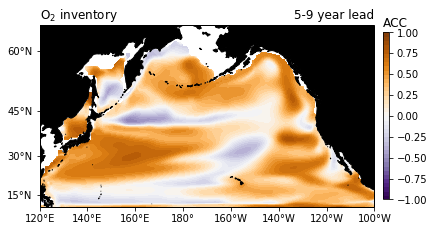

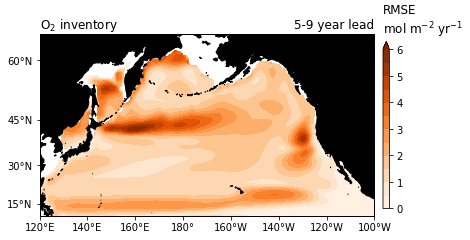

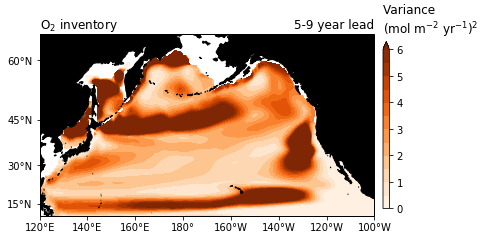

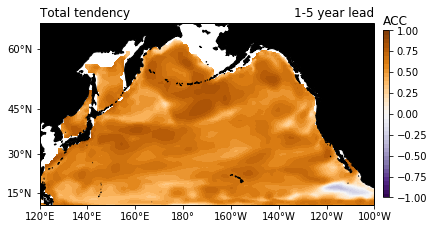

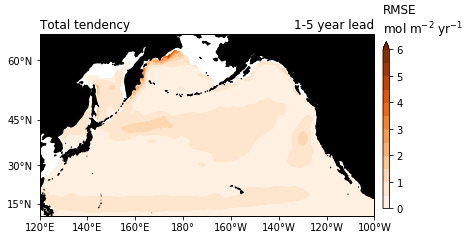

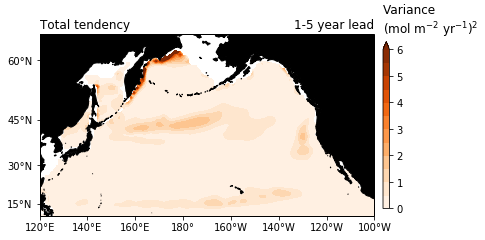

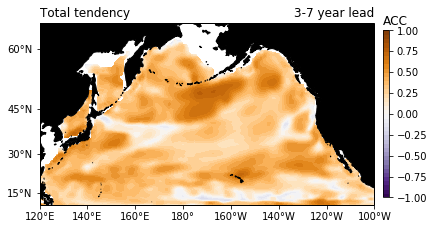

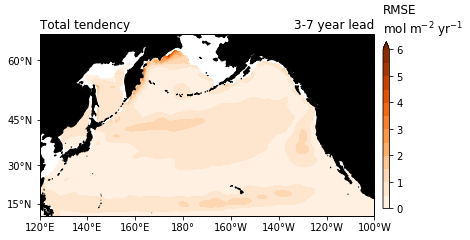

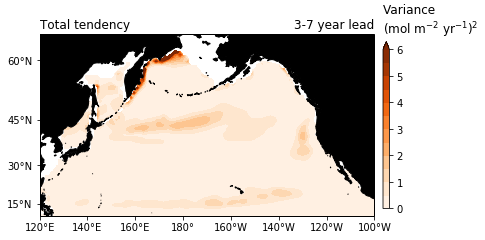

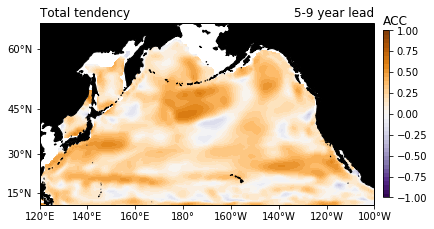

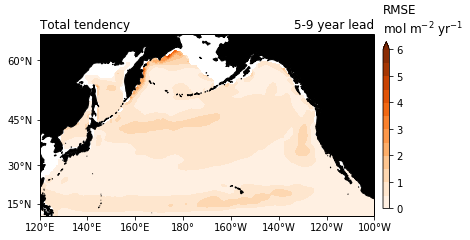

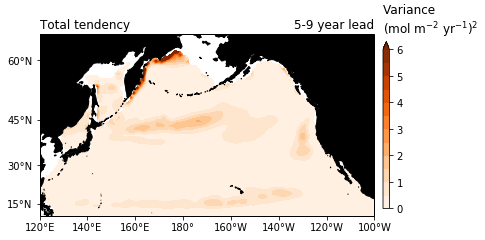

In [15]:
extent = [120,260,10,65]
prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]),
                    min_latitude=extent[2],
                    max_latitude=extent[3])

for vbase in ['O2_zint','O2_rhs_tend']:

    for j,forecast_lead in enumerate(forecast_leads):
        for vsuffix in ['acc','rmse','var']:
            fig = plt.figure()
            axi = fig.add_subplot(1,1,1,projection=prj)

            v = '_'.join([vbase,vsuffix])

            axi.set_extent(extent)
            lon,lat,field = pt.adjust_pop_grid(skill.TLONG.values,skill.TLAT.values,skill[v].isel(forecast_lead=j))

            cf = axi.contourf(lon,lat,field,**cf_specs[vsuffix],transform=ccrs.PlateCarree())
            land = axi.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','50m',
                          edgecolor='k',
                          facecolor='k'))

            axi.set_title(skill[v].attrs['long_name'],loc='left')
            axi.set_title(f'{forecast_lead[0]}-{forecast_lead[1]} year lead',loc='right') 

            axi.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
            axi.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()
            axi.xaxis.set_major_formatter(lon_formatter)
            axi.yaxis.set_major_formatter(lat_formatter)

            plt.subplots_adjust(wspace=0.1,hspace=0.01,right=0.9)

            ptop = ax[1].get_position()
            pbot = ax[-1].get_position()

            height = ptop.y0 + ptop.height - pbot.y0
            cbar_height = 0.58
            y0 = pbot.y0+height/2-cbar_height/2 

            cax = plt.axes((0.92,y0,0.015,cbar_height))
            cax.set_title(cax_title[vsuffix],loc='left')
            plt.colorbar(cf,cax=cax)    
            
            plt.savefig(f'{P.dirf}/CESM-DPLE-npac-tend-skill-{forecast_lead[0]}-{forecast_lead[1]}y-{vbase}-{vsuffix}.pdf',dpi=300,bbox_inches='tight')        

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


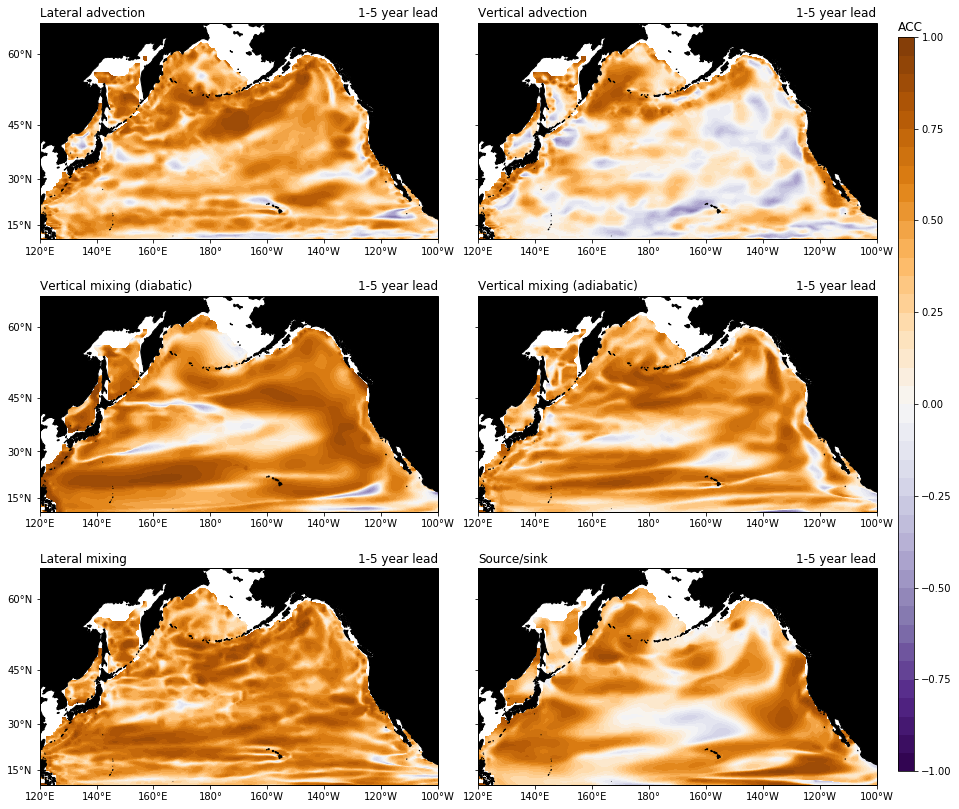

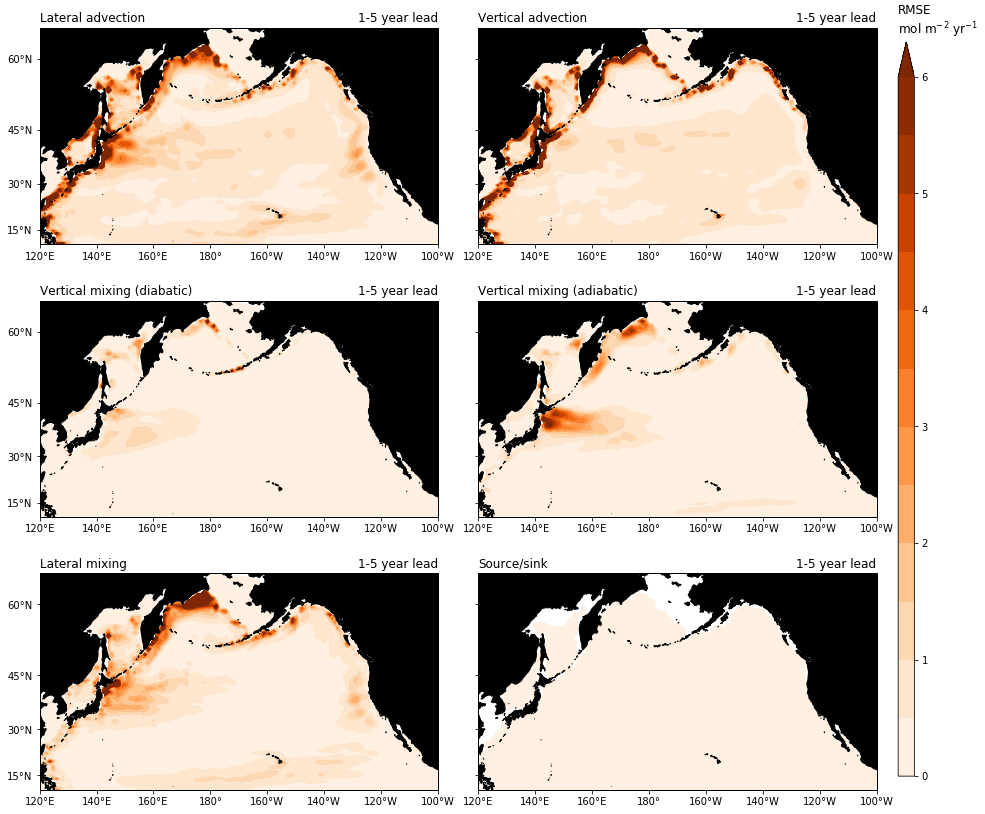

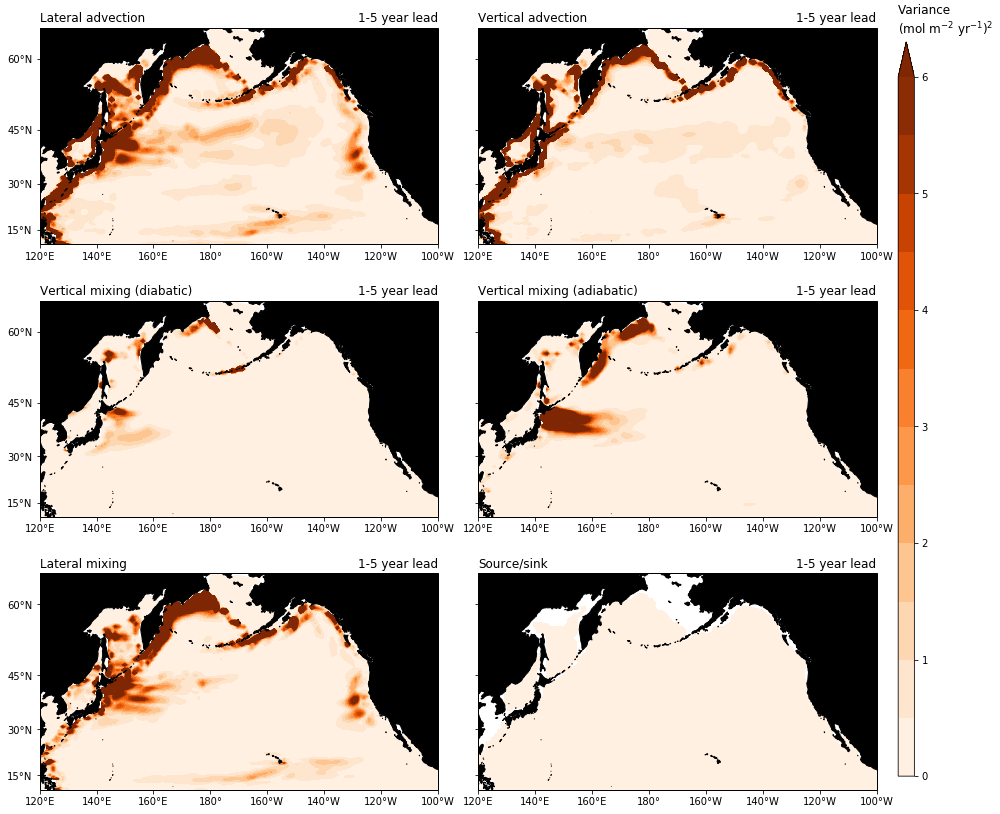

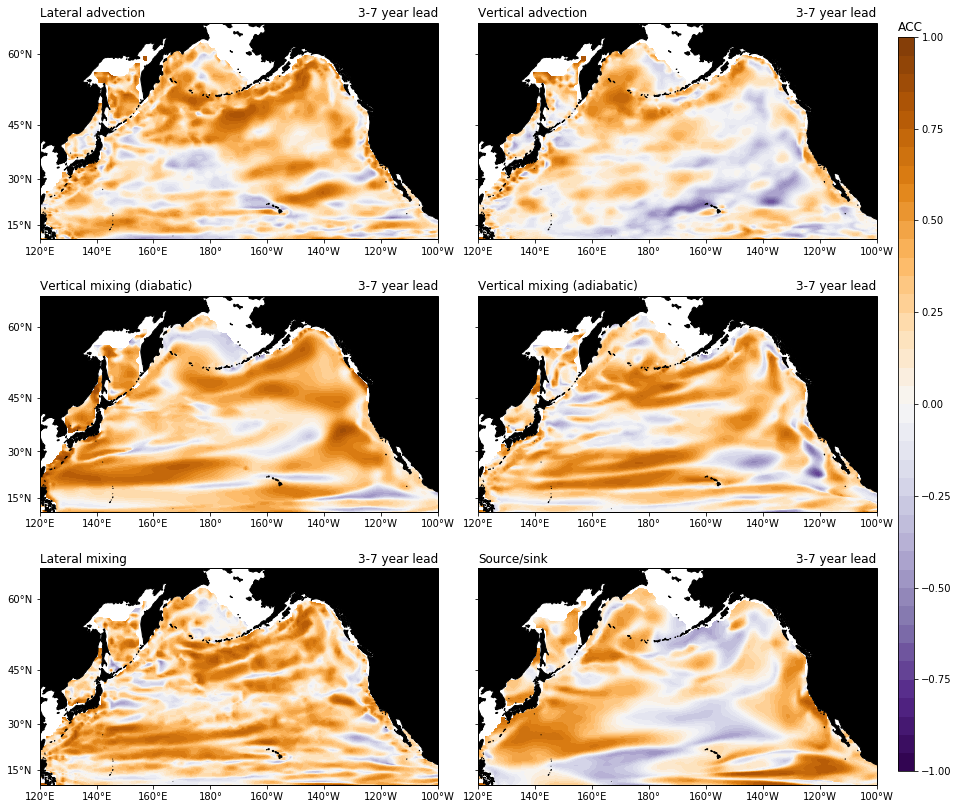

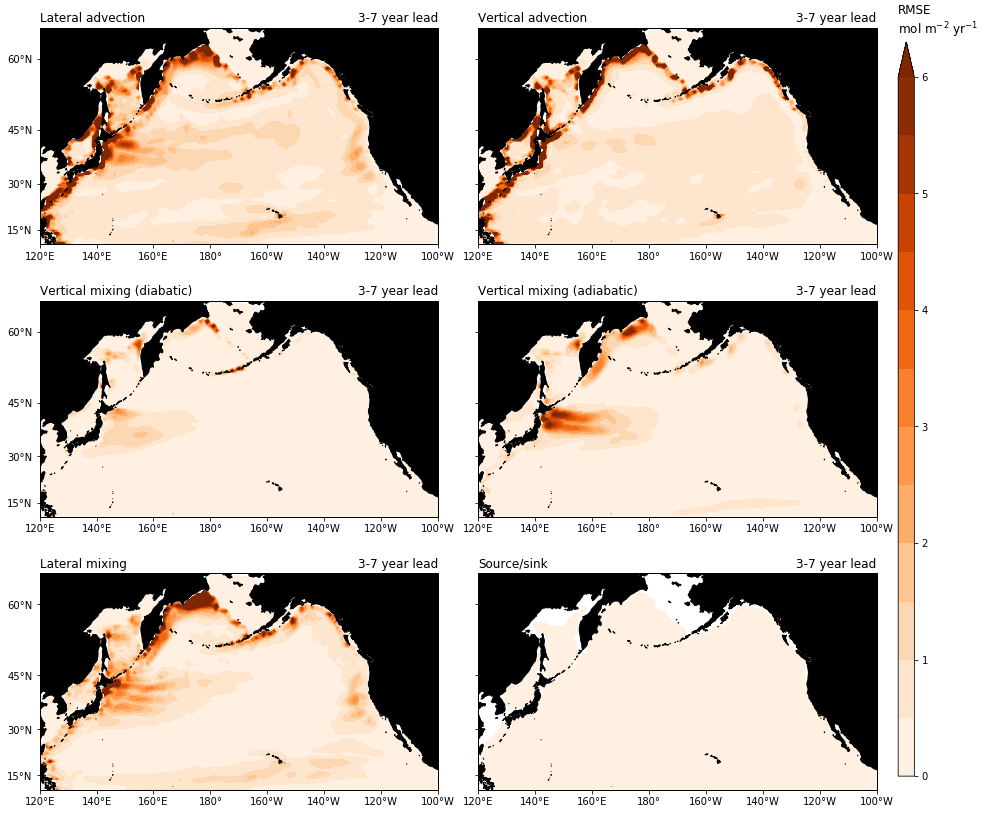

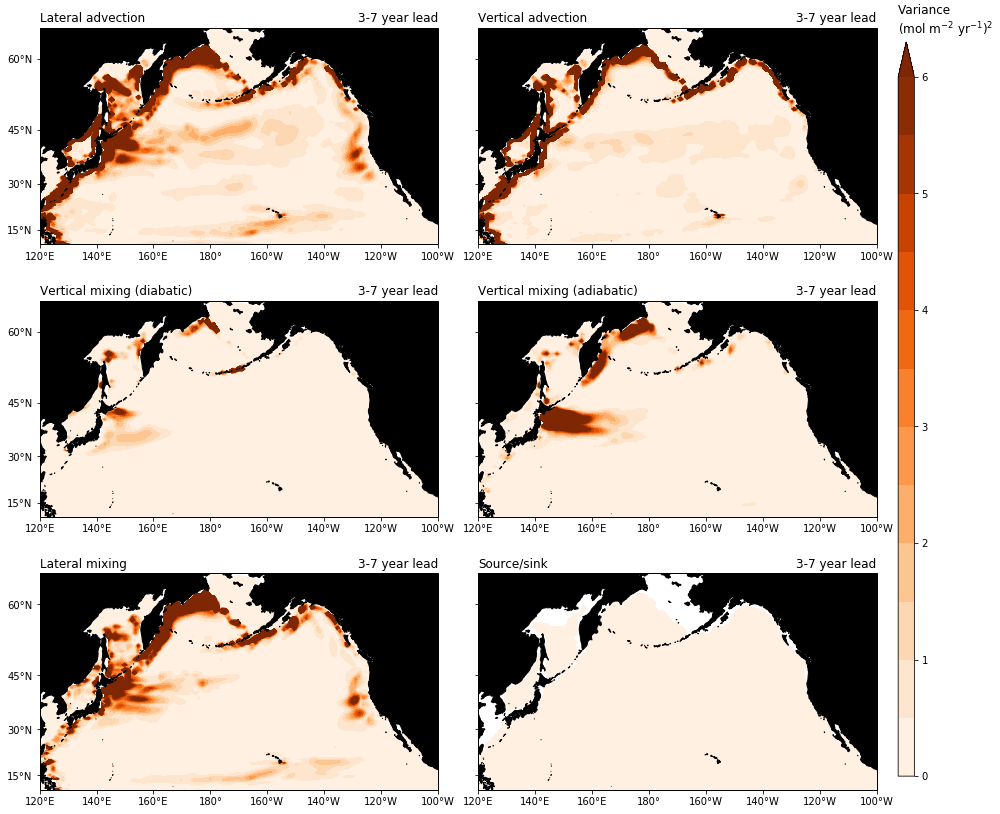

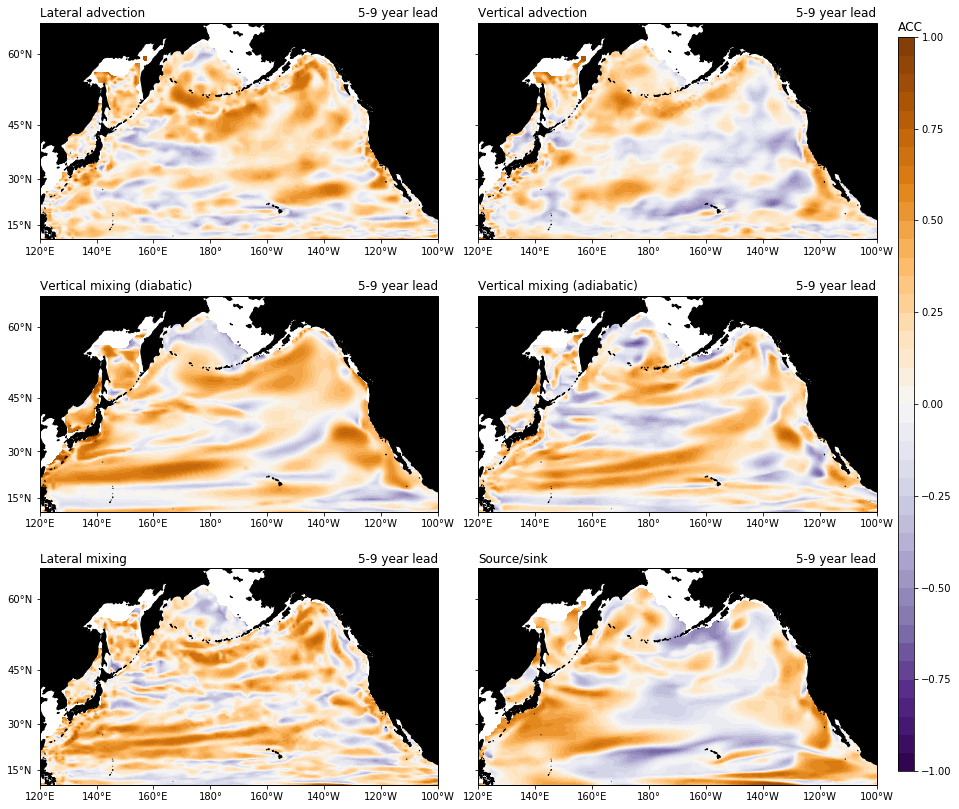

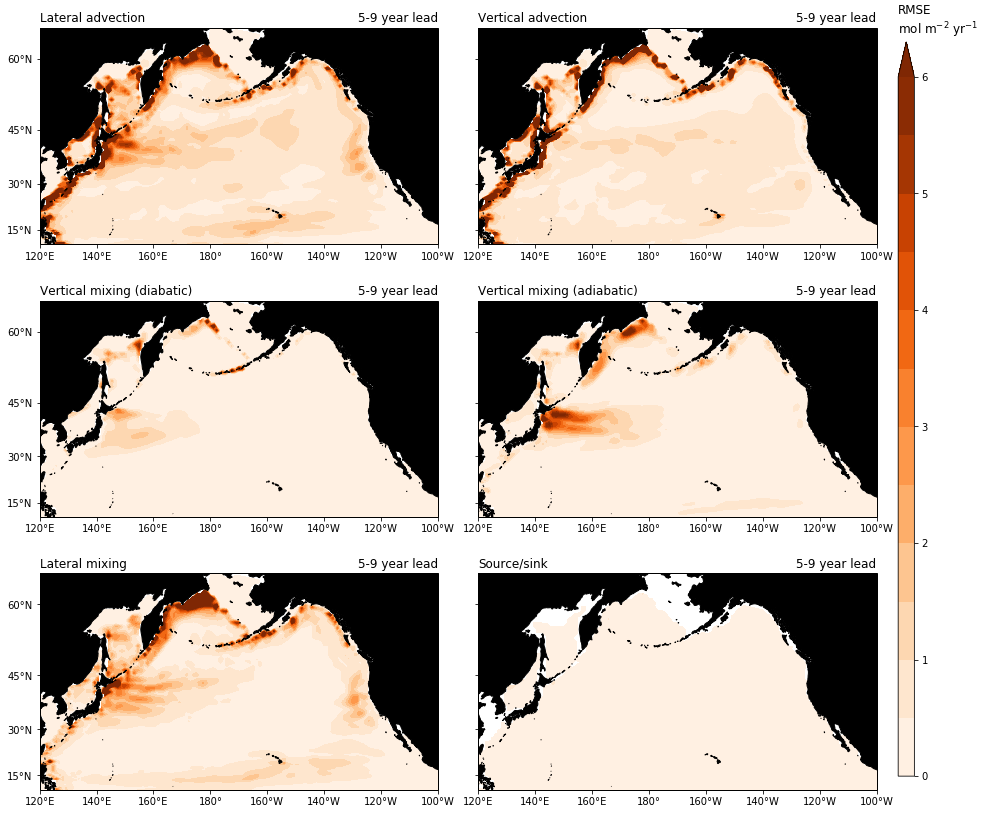

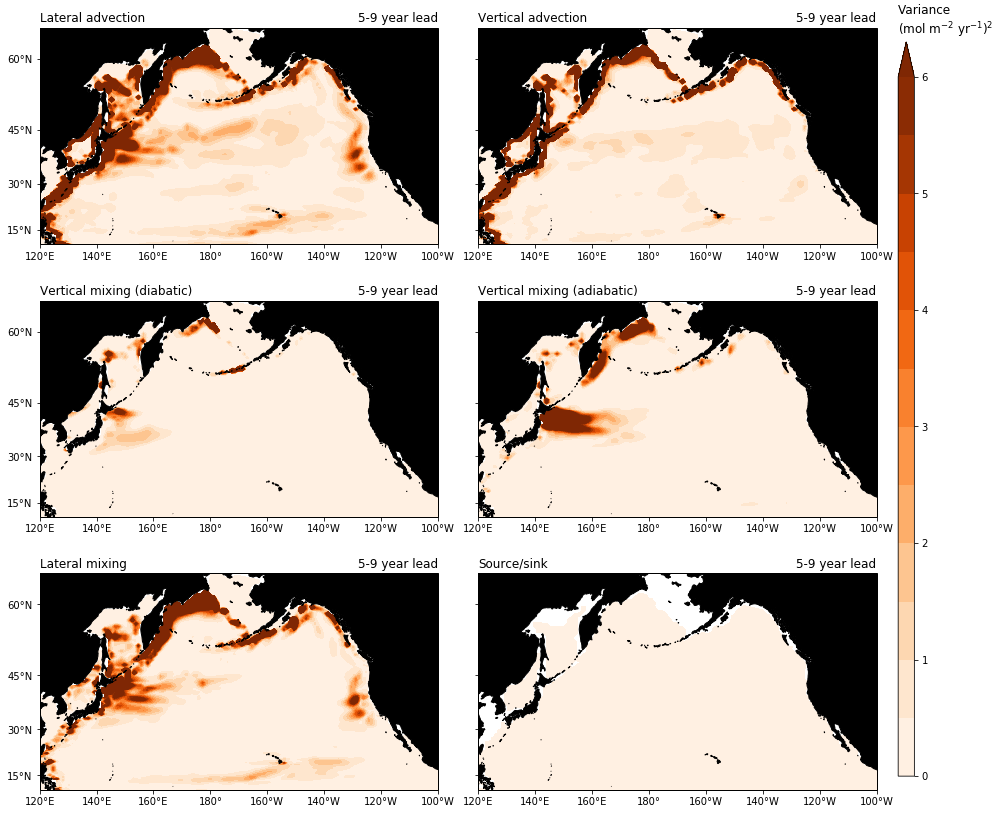

In [9]:
extent = [120,260,10,65]
prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]),
                    min_latitude=extent[2],
                    max_latitude=extent[3])


for j,forecast_lead in enumerate(forecast_leads):
    for vsuffix in ['acc','rmse','var']:
        
        fig = plt.figure(figsize=(15,15))
        ax = []
        for i,vbase in enumerate(tend_variables):
            
            v = '_'.join([vbase,vsuffix])
            
            axi = fig.add_subplot(3,2,i+1,projection=prj)
            axi.set_extent(extent)
            lon,lat,field = pt.adjust_pop_grid(skill.TLONG.values,skill.TLAT.values,skill[v].isel(forecast_lead=j))

            cf = axi.contourf(lon,lat,field,**cf_specs[vsuffix],transform=ccrs.PlateCarree())
            land = axi.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','50m',
                          edgecolor='k',
                          facecolor='k'))

            axi.set_title(skill[v].attrs['long_name'],loc='left')
            axi.set_title(f'{forecast_lead[0]}-{forecast_lead[1]} year lead',loc='right') 

            axi.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
            axi.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()
            axi.xaxis.set_major_formatter(lon_formatter)
            axi.yaxis.set_major_formatter(lat_formatter)

            if i%2 != 0:
                axi.set_yticklabels([])
            ax.append(axi)

        plt.subplots_adjust(wspace=0.1,hspace=0.01,right=0.9)

        ptop = ax[1].get_position()
        pbot = ax[-1].get_position()

        height = ptop.y0 + ptop.height - pbot.y0
        cbar_height = 0.68
        y0 = pbot.y0+height/2-cbar_height/2 

        cax = plt.axes((0.92,y0,0.015,cbar_height))
        cax.set_title(cax_title[vsuffix],loc='left')
        plt.colorbar(cf,cax=cax)    

        plt.savefig(f'{P.dirf}/CESM-DPLE-npac-tend-skill-{forecast_lead[0]}-{forecast_lead[1]}y-{vsuffix}.pdf',dpi=300,bbox_inches='tight')        